## 규제 선형 모델 - 릿지, 리쏘, 엘라스틱넷

### 규제 선형 모델의 개요

머신러닝에서 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 한다.  
  
이전에는  선형 모델의 비용 함수 RSS를 최소화 하는, 즉 실제값과 예측값의 차이를 최소화 하는 것에만 우선순위를 두었다. 그러다 보니 학습 데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커지는 현상을 볼 수 있었다. 이럴 경우 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉽다.  
  
이를 반영해 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이뤄야 한다.

이렇게 회귀 계수의 크기를 제어해 과적합을 개선하려면 비용(Cost) 함수의 목표(Gola of RSS)가 최소화하는 것으로 변경될 수 있다.  
  
$$ \text{Goal of RSS} = Min(RSS(W) + alpha*||W||_2^2) $$  
  
여기서 $alpha$는 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터이다.  
비용 함수의 목표가 $RSS(W) + alpha*||W||_2^2$를 최소화하는 $W$ 벡터를 찾는 것일 때, $alpha$가 어떤 역할을 하는지 알아보자

$alpha$가 0(또는 매우 작은 값)이라면 비용 함수 식은 기존과 동일한 $Min(RSS(W) + 0)$이 될 것이다. 반면에 $alpha$가 무한대로 큰 값이라면 비용 함수 식은 $RSS(W)$에 비해 $alpha*||W||_2^2$ 값이 너무 커지게 되므로 W 값을 0(또는 매우 작게)으로 만들어야 Cost가 최소화되는 비용 함수 목표를 달성할 수 있다.  
  
즉, $alpha$ 값을 크게 하면 비용 함수는 회귀 계수 $W$ 값을 작게 해 과적합을 개선할 수 있으며 $alpha$ 값을 작게 하면 회귀 계수 $W$ 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있다.

$alpha$를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있다. 이처럼 비용 함수에 $alpha$ 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 `규제(Regularization)`라고 부른다.  
  
* L2 규제 : $alpha * ||W||_2^2$와 같이 $W$의 제곱에 대해 페널티를 부여하는 방식  
`릿지(Ridge)` 회귀라고 한다  
* L1 규제 : $alpha * ||W||_1$와 같이 $W$의 절댓값에 대해 페널티를 부여하는 방식  
`라쏘(Lasso)` 회귀라고 한다. L1 규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환

### 릿지 회귀

앞의 예제에서 사용한 `LinearRegression` 예제에서 사용한 피처 데이터 세트인 `X_data`와 Target 데이터 세트인 `y_target`을 그대로 이용한다

In [18]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
%matplotlib inline

boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston dataset의 target array는 주택 가격. 이를 PRICE 칼럼으로 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 :', bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

Boston 데이터셋 크기 : (506, 14)
 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


릿지의 5개 폴드의 평균 RMSE가 5.518로 앞선 예제의 RMSE 보다 뛰어난 예측 성능을 보인다.  
  
이제 릿지의 $alpha$ 값을 0, 0.1, 1, 10, 100으로 변화시키면서 RMSE 와 회귀 계수 값의 변화를 살펴보자

In [19]:
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse를 구함
for i in alphas:
    ridge = Ridge(alpha = i)
    
    # cross_val_score를 이용하여 5Fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(i,avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


$alpha = 100$ 일때 RMSE가 5.33으로 가장 좋다.

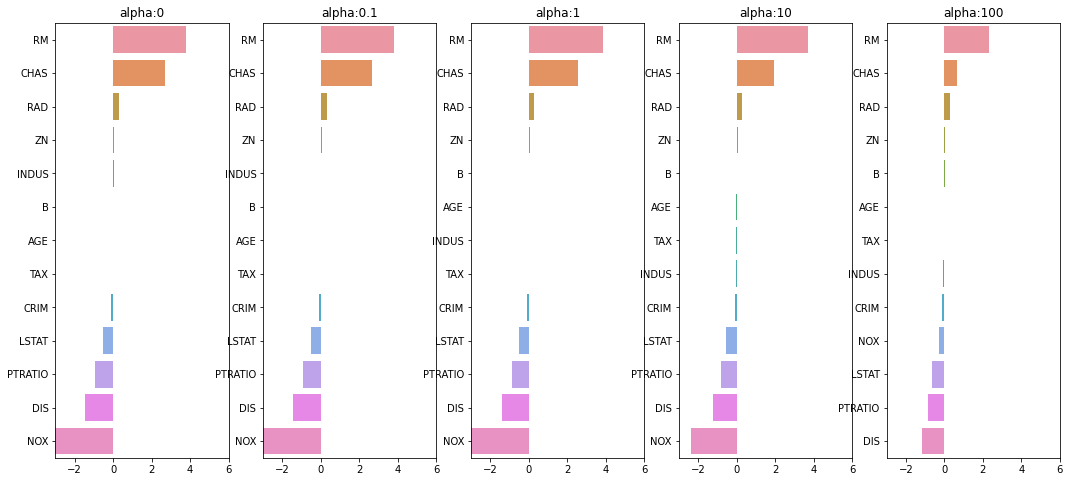

In [24]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성 
fig, axs = plt.subplots(figsize = (18,8), nrows = 1, ncols = 5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alpha 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장
# pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff
    
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

$alpha$값을 증가할 때 마다 전체적으로 회귀 계수의 값이 감소함을 알 수 있다.

In [26]:
# alpha값에 따른 칼럼별 회귀계수 출력
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


회귀 계수가 지속적으로 작아짐을 직관적으로 알 수 있다.  
__릿지 회귀는 회귀 계수를 0으로 만들지는 않는다.__

### 라쏘 회귀

$W$의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘(Lasso)회귀이다.   
즉,  L1 규제는 $alpha * ||W||_1$을 의미하며, 라쏘 회귀 비용함수의 목표는 $RSS(W) + alpha*||W||_1$ 식을 최소화하는 $W$를 찾는 것이다.  
  
L2 규제가 회귀 계수의 크기를 감소시키는데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거한다. 이러한 측면에서 L1 규제는 적절한 피처만 회귀에 포함시키는 __피처 선택의 특성__을 가진다.

In [35]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

In [36]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


$alpha = 0.07$ 일 때 가장 좋은 RMSE 평균을 가진다.

In [37]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


$alpha$의 크기가 증가함에 따라 일부 회귀 계수는 아예 0으로 바뀌었다.  
회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있다.

### 엘라스틱넷 회귀

`엘라스틱넷(Elastic Net)` 회귀는 L2 규제와 L1 규제를 결합한 회귀이다. 따라서 엘라스틱넷 회귀 비용함수의 목표는
$RSS(W) + alpha2 * ||W||_2^2 + alpha1 * ||W||_1$ 식을 최소화하는 $W$를 찾는 것이다.  
  
엘라스틱넷은 라쏘 회귀가 서로 상관계수가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강하다. 특히 이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급격히 변동할 수 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것.  
  
반대로 엘라스틱넷 회귀의 단점은 L1과 L2 규제가 결합된 규제로 인해 수행시간이 오래 걸린다는 점이다.

In [38]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [39]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


$alpha = 0.5$ 일 때 RMSE가 5.467로 가장 좋은 예측 성능을 보인다.  
$alpha$ 값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있다.

### 선형 회귀 모델을 위한 데이터 변환

선형 회귀 모델과 같은 선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고, 이러한 최적이 선형함수를 찾아내 결과값을 예측한다. 선형 회귀 모델은 피처 값과 타깃값의 분포가 정규분포 형태를 가지는 것을 매우 선호한다.  
  
특히 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우진 왜곡된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높다. 피처값 역시 결정값보다는 덜하지만 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 가능성이 높다.  
  
따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적이다. 하지만 이러한 스케일링/정규화 작업을 선행핟나고 무조건 예측 성능이 향상되는 것은 아니다. 일반적으로 중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 경우에 이러한 변환 작업을 수행한다.

1. `StandardScaler` 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 `MinMaxScale`r 클래스를 이용해 최솟값이 0이고 최댓값이 1인 값으로 정규화 수행  
  
2. 스케일링/정규화를 수행한 데이터 세트에 다시 `다항 특성`을 적용하여 변환하는 방법. 보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 이와 같은 방법 적용  
  
3. 원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포. 이러한 변환을 `로그 변환`이라 명칭. 1번 방법의 경우 예측 성능 향상을 드라마틱하게 기대하긴 어렵고, 2번 방법의 경우 피처의 개수가 매우 많을 경우 다항 변화으로 생성되는 피처의 개수가 기하급수적으로 늘어나 과적합이 발생 할 수도 있기 때문에 매우 유용한 변환  
  
__타깃값의 경우는 일반적으로 로그 변환을 적용한다.__ 결정 값을 정규 분포나 다른 정규값으로 변환하면 변환된 값을 다시 원본 타깃값으로 원복하기 어려울 수 있기 때문.

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
        
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [42]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출. 
alphas = [0.1, 1, 10, 100]

# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성(2차 다항식), 로그변환 
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], 
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMS